[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/krasserm/bayesian-machine-learning/blob/master/bayesian_optimization.ipynb)

# Bayesian optimization

## Introduction 

Many optimization problems in machine learning are black box optimization problems where the objective function $f(\mathbf{x})$ is a black box function<sup>[1][2]</sup>. We do not have an analytical expression for $f$ nor do we know its derivatives. Evaluation of the function is restricted to sampling at a point $\mathbf{x}$ and getting a possibly noisy response. 

If $f$ is cheap to evaluate we could sample at many points e.g. via grid search, random search or numeric gradient estimation. However, if function evaluation is expensive e.g. tuning hyperparameters of  a deep neural network, probe drilling for oil at given geographic coordinates or evaluating the effectiveness of a drug candidate taken from a chemical search space then it is important to minimize the number of samples drawn from the black box function $f$.

This is the domain where Bayesian optimization techniques are most useful. They attempt to find the global optimimum in a minimum number of steps. Bayesian optimization incorporates prior belief about $f$ and updates the prior with samples drawn from $f$ to get a posterior that better approximates $f$. The model used for approximating the objective function is called *surrogate model*. Bayesian optimization also uses an *acquisition function* that directs sampling to areas where an improvement over the current best observation is likely.

### Surrogate model

A popular surrogate model for Bayesian optimization are [Gaussian processes](https://en.wikipedia.org/wiki/Gaussian_process) (GPs). I wrote about Gaussian processes in a [previous post](https://krasserm.github.io/2018/03/19/gaussian-processes/). If you are not familiar with GPs I recommend reading it first. GPs define a prior over functions and we can use them to incorporate prior beliefs about the objective function (smoothness, ...). The GP posterior is cheap to evaluate and is used to propose points in the search space where sampling is likely to yield an improvement. 

### Acquisition functions

Proposing sampling points in the search space is done by acquisition functions. They trade off exploitation and exploration. Exploitation means sampling where the surrogate model predicts a high objective and exploration means sampling at locations where the prediction uncertainty is high. Both correspond to high acquisition function values and the goal is to maximize the acquisition function to determine the next sampling point. 



More formally, the objective function $f$ will be sampled at $\mathbf{x}_t = \mathrm{argmax}_{\mathbf{x}} u(\mathbf{x} \lvert \mathcal{D}_{1:t-1})$ where $u$ is the acquisition function and $\mathcal{D}_{1:t-1} = \{(\mathbf{x}_1, y_1),...,(\mathbf{x}_{t-1}, y_{t-1})\}$ are the $t-1$ samples drawn from $f$ so far. Popular acquisition functions are *maximum probability of improvement* (MPI), *expected improvement* (EI) and *upper confidence bound* (UCB)<sup>[1]</sup>. In the following, we will use the expected improvement (EI) which is most widely used and described further below. 

### Optimization algorithm

The Bayesian optimization procedure is as follows. For $t = 1,2,...$ repeat:

- Find the next sampling point $\mathbf{x}_{t}$ by optimizing the acquisition function over the GP: $\mathbf{x}_t = \mathrm{argmax}_{\mathbf{x}} u(\mathbf{x} \lvert \mathcal{D}_{1:t-1})$
- Obtain a possibly noisy sample $y_t = f(\mathbf{x}_t) + \epsilon_t$ from the objective function $f$.
- Add the sample to previous samples $\mathcal{D}_{1:t} = \{\mathcal{D}_{1:t-1}, (\mathbf{x}_t,y_t)\}$ and update the GP.

### Expected improvement

Expected improvement is defined as

$$\mathrm{EI}(\mathbf{x}) = \mathbb{E}\max(f(\mathbf{x}) - f(\mathbf{x}^+), 0)\tag{1}$$

where $f(\mathbf{x}^+)$ is the value of the best sample so far and $\mathbf{x}^+$ is the location of that sample i.e. $\mathbf{x}^+ = \mathrm{argmax}_{\mathbf{x}_i \in \mathbf{x}_{1:t}} f(\mathbf{x}_i)$. The expected improvement can be evaluated analytically under the GP model<sup>[3]</sup>:

$$
\mathrm{EI}(\mathbf{x}) =
\begin{cases}
(\mu(\mathbf{x}) - f(\mathbf{x}^+) - \xi)\Phi(Z) + \sigma(\mathbf{x})\phi(Z)  &\text{if}\ \sigma(\mathbf{x}) > 0 \\
0 & \text{if}\ \sigma(\mathbf{x}) = 0
\end{cases}\tag{2}
$$

where

$$
Z =
\begin{cases}
\frac{\mu(\mathbf{x}) - f(\mathbf{x}^+) - \xi}{\sigma(\mathbf{x})} &\text{if}\ \sigma(\mathbf{x}) > 0 \\
0 & \text{if}\ \sigma(\mathbf{x}) = 0
\end{cases}
$$

where $\mu(\mathbf{x})$ and $\sigma(\mathbf{x})$ are the mean and the standard deviation of the GP pesterior predictive at $\mathbf{x}$, respectively. $\Phi$ and $\phi$ are the CDF and PDF of the standard normal distribution, respectively. The first summation term in Equation (2) is the exploitation term and second summation term is the exploration term.

Parameter $\xi$ in Equation (2) determines the amount of exploration during optimization and higher $\xi$ values lead to more exploration. In other words, with increasing $\xi$ values, the importance of improvements predicted by the GP posterior mean $\mu(\mathbf{x})$ decreases relative to the importance of potential improvements in regions of high prediction uncertainty, represented by large $\sigma(\mathbf{x})$ values. A recommended default value for $\xi$ is $0.01$.

With this minimum of theory we can start implementing Bayesian optimization. The next section shows a basic implementation with plain NumPy and SciPy, later sections demonstrate how to use existing libraries. Finally, Bayesian optimization is used to tune the hyperparameters of a tree-based regression model.

## Bayesian optimization libraries

There are numerous Bayesian optimization libraries out there and giving a comprehensive overview is not the goal of this article. Instead, I'll pick two that I used in the past and show the minimum setup needed to get the previous example running.

### Scikit-optimize

[Scikit-optimize](https://scikit-optimize.github.io/) is a library for sequential model-based optimization that is based on [scikit-learn](http://scikit-learn.org/). It also supports Bayesian optimization using Gaussian processes. The API is designed around minimization, hence, we have to provide negative objective function values.  The results obtained here slightly differ from previous results because of non-deterministic optimization behavior and different noisy samples drawn from the objective function.

## GPyOpt

[GPyOpt](http://sheffieldml.github.io/GPyOpt/) is a Bayesian optimization library based on [GPy](https://sheffieldml.github.io/GPy/). The abstraction level of the API is comparable to that of scikit-optimize. The `BayesianOptimization` API provides a `maximize` parameter to configure whether the objective function shall be maximized or minimized (default). In version 1.2.1, this seems to be ignored when providing initial samples, so we have to negate their target values manually in the following example. Also, the built-in `plot_acquisition` and `plot_convergence` methods display the minimization result in any case. Again, the results obtained here slightly differ from previous results because of non-deterministic optimization behavior and different noisy samples drawn from the objective function. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

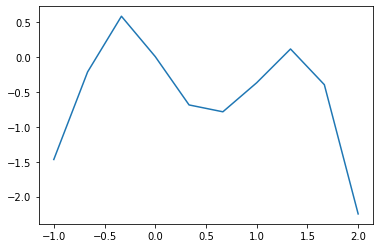

In [10]:
mesh = np.linspace(-1,2, 10)
plt.plot(mesh, f(mesh))

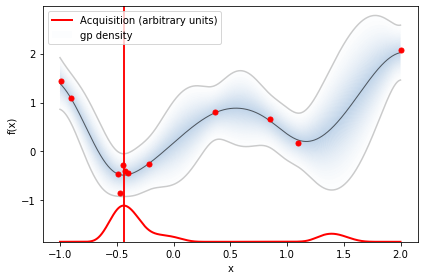

In [3]:
import GPy
import GPyOpt

from GPyOpt.methods import BayesianOptimization

kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
bds = [{'name': 'X', 'type': 'continuous', 'domain': bounds.ravel()}]

optimizer = BayesianOptimization(f=f, 
                                 domain=bds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 X=X_init,
                                 Y=-Y_init,
                                 noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True)

optimizer.run_optimization(max_iter=10)
optimizer.plot_acquisition()

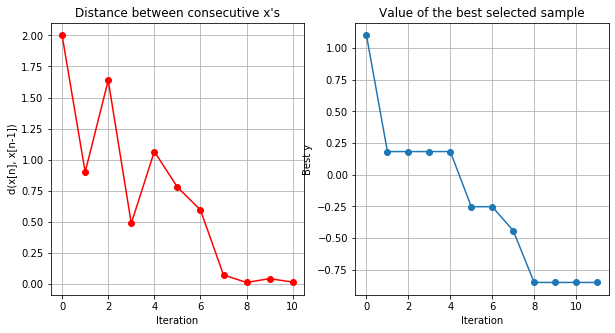

In [4]:
optimizer.plot_convergence()

## Application

This section demonstrates how to optimize the hyperparameters of an `XGBRegressor` with GPyOpt and how Bayesian optimization performance compares to random search. `XGBRegressor` is part of [XGBoost](https://xgboost.readthedocs.io/), a flexible and scalable gradient boosting library. `XGBRegressor` implements the scikit-learn estimator API and can be applied to regression problems. Regression is performed on a small [toy dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes) that is part of scikit-learn.

In [5]:
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from scipy.stats import uniform
from xgboost import XGBRegressor

# Load the diabetes dataset (for regression)
X, Y = datasets.load_diabetes(return_X_y=True)

# Instantiate an XGBRegressor with default hyperparameter settings
xgb = XGBRegressor(objective='reg:squarederror')

# and compute a baseline to beat with hyperparameter optimization 
baseline = cross_val_score(xgb, X, Y, scoring='neg_mean_squared_error').mean()

In [6]:
baseline

-3437.074407214106

### Hyperparameter tuning with random search

For hyperparameter tuning with random search, we use `RandomSearchCV` of scikit-learn and compute a cross-validation score for each randomly selected point in hyperparameter space. Results will be discussed below.

In [7]:
# Hyperparameters to tune and their ranges
param_dist = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10)}

rs = RandomizedSearchCV(xgb, param_distributions=param_dist, 
                        scoring='neg_mean_squared_error', n_iter=25)

# Run random search for 25 iterations
rs.fit(X, Y);

### Hyperparameter tuning with Bayesian optimization

To tune hyperparameters with Bayesian optimization we implement an objective function `cv_score` that takes hyperparameters as input and returns a cross-validation score. Here, we assume that cross-validation at a given point in hyperparameter space is deterministic and therefore set the `exact_feval` parameter of `BayesianOptimization` to `True`. Depending on model fitting and cross-validation details this might not be the case but we ignore that here.

In [8]:
bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)},
        {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}]

# Optimization objective 
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
                XGBRegressor(objective='reg:squarederror', 
                             learning_rate=parameters[0],
                              gamma=int(parameters[1]),
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              min_child_weight = parameters[4]), 
                X, Y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True)

# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=20)

### Results

On average, Bayesian optimization finds a better optimium in a smaller number of steps than random search and beats the baseline in almost every run. This trend becomes even more prominent in higher-dimensional search spaces. Here, the search space is 5-dimensional which is rather low to substantially profit from Bayesian optimization. One advantage of random search is that it is trivial to parallelize. Parallelization of Bayesian optimization is much harder and subject to research (see \[4\], for example).

Baseline neg. MSE = -3437.07
Random search neg. MSE = -3568.94
Bayesian optimization neg. MSE = -4026.15


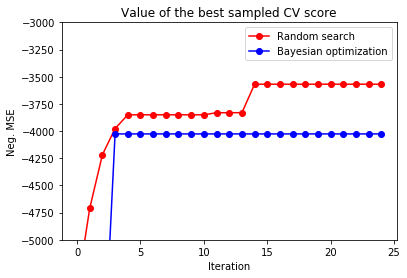

In [9]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

print(f'Baseline neg. MSE = {baseline:.2f}')
print(f'Random search neg. MSE = {y_rs[-1]:.2f}')
print(f'Bayesian optimization neg. MSE = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.ylim(-5000, -3000)
plt.title('Value of the best sampled CV score');
plt.legend();

## References

\[1\] Eric Brochu, Vlad M. Cora, Nando de Freitas, [A Tutorial on Bayesian Optimization of Expensive Cost Functions](https://arxiv.org/abs/1012.2599).  
\[2\] Jonas Mockus, [Application of Bayesian approach to numerical methods of global and stochastic optimization](https://link.springer.com/article/10.1007/BF01099263).  
\[3\] Donald R. JonesMatthias SchonlauWilliam J. Welch, [Efficient Global Optimization of Expensive Black-Box Functions](https://link.springer.com/article/10.1023/A:1008306431147).  
\[4\] Jialei Wang, Scott C. Clark, Eric Liu, Peter I. Frazier, [Parallel Bayesian Global Optimization of Expensive Functions](https://arxiv.org/abs/1602.05149).  